# Cloud Optimized GeoTIFFs (COGs)

- https://www.cogeo.org/in-depth.html
- https://github.com/cogeotiff/cog-spec/blob/master/spec.md
- https://github.com/cogeotiff/rio-cogeo/blob/master/rio_cogeo/cogeo.py
- https://github.com/amfriesz/eros_cop_webinar_notebooks/blob/4732ca3f489f7e5b1ce4e49ce9ef3de8260f05ab/Topic_2__Cloud_Optimized_Data_and_STAC.ipynb
- https://kylebarron.dev/blog/cog-mosaic/overview

### PyStac Resources

- https://www.element84.com/earth-search/
- https://github.com/stac-utils/pystac-client/blob/9e010adcce4a4aebb458e7b107ac1143ca3ccbb6/docs/tutorials/pystac-client-introduction.ipynb
- https://github.com/radiantearth/stac-api-spec/blob/master/fragments/itemcollection/README.md

#### Histogram Stretching/Contrast Stretching
- https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

#### AOI search COG
- https://www.acgeospatial.co.uk/cog-part-2-python/
- https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html
- https://geojson.io/

## Cloud-Optimized GeoTIFFs
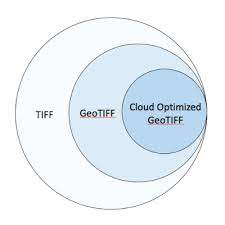
As described on cogeo.org:

A Cloud Optimized GeoTIFF (COG) is a regular GeoTIFF file, aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud. It does this by leveraging the ability of clients issuing ​HTTP GET range requests to ask for just the parts of a file they need.

This new format is at the core of dynamic tiling. By making use of its internal image overviews, one can read parts of the image over a network roughly in proportion to the amount of data requested. The client needs only to read the file's inital metadata to know the exact pattern and byte ranges of the rest of the file. Then to read an image's top-right corner at mid-resolution, a minimal number of additional requests can be made just for that data.

#### Tiling 
creates a number of internal ‘tiles’ inside the actual image, instead of using simple ‘stripes’ of data. With a stripe of data then the whole file needs to be read to get the key piece. With tiles much quicker access to a certain area is possible, so that just the portion of the file that needs to be read is accessed.

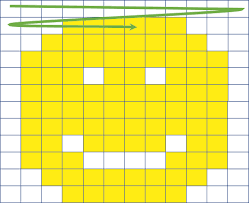


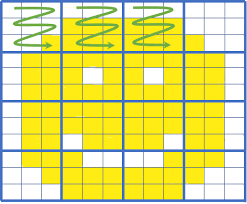

#### Overviews 
create downsampled versions of the same image. This means it’s ‘zoomed out’ from the original image - it has much less detail (1 pixel where the original might have 100 or 1000 pixels), but is also much smaller. Often a single GeoTIFF will have many overviews, to match different zoom levels. These add size to the overall file, but are able to be served much faster, since the renderer just has to return the values in the overview instead of figuring out how to represent 1000 different pixels as one.

These, along with compression of the data, are general best practices for enabling software to quickly access imagery. But they are even more important to enable the HTTP GET Range requests to work efficiently.

![overviews.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRoKEIs5oupwTjrt5AUsUUavHWPtKz3dhKQWQ&usqp=CAU)

#### Bringing it together
The Tiling and Overviews in the GeoTIFF put the right structure on the files on the cloud so that the Range queries can request just the part of the file that is relevant.

Overviews come into play when the client wants to render a quick image of the whole file - it doesn’t have to download every pixel, it can just request the much smaller, already created, overview. The structure of the GeoTIFF file on an HTTP Range supporting server enables the client to easily find just the part of the whole file that is needed.

Tiles come into play when some small portion of the overall file needs to be processed or visualized. This could be part of an overview, or it could be at full resolution. But the tile organizes all the relevant bytes of an area in the same part of the file, so the Range request can just grab what it needs.

If the GeoTIFF is not ‘cloud optimized’ with overviews and tiles then doing remote operations on the data will still work. But they may download the whole file or large portions of it when only a very small part of the data is actually needed.

### Useful Libraries

### rio-tiler
rio-tiler is at the core of the ecosystem. It's a library whose main purpose is to create a mercator tile from a given input image. In contrast to some of the following libraries, it takes a single input path and returns a single output image. It forms the core of some other libraries.

### rio-tiler-mosaic
rio-tiler-mosaic builds upon rio-tiler to work with multiple assets. It takes a list of assets that are already known to overlap with the tile, and combines them into an image aligned with a web mercator tile.

### cogeo-mosaic
cogeo-mosaic is a Python library to create MosaicJSON files and load such files from various backends. In the upcoming 3.0 release, new support exists for storing a MosaicJSON in a variety of locations, including in a DynamoDB table. For large mosaics, DynamoDB is significantly faster than loading a JSON file from an S3 bucket.

### rio-cogeo
rio-cogeo is a library to facilitate creating COGs. Also used to help build our COG validation workflow where we utilize some of their functionality to check GeoTIFFs to determine if they are in COG formatting or not.

## Some common attributes looking for in a COG (tiled (256/512), compression-deflate, crs-UTM projection, overviews-internal/external)

In [1]:
import rasterio as rio
from shapely.geometry import Polygon
import json
from pystac_client import Client
import geopandas as gpd
%matplotlib inline
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask

## AOI  Search

In [2]:
def se_return_catalog(sensor):
    
    landsat_stac = Client.open('https://landsatlook.usgs.gov/stac-server')
    sentinel_stac = Client.open('https://earth-search.aws.element84.com/v0')
    
    collections = {'landsat': ['landsat-c2l2-sr'],
         'sentinel-2': ['sentinel-s2-l2a-cogs']}
    
    if sensor == 'landsat':
        catalog = landsat_stac
    elif sensor == 'sentinel-2':
        catalog = sentinel_stac
    
    collection = collections[sensor]
    
    return catalog, collection

In [3]:
def se_return_centroid_point(geojson):
    df = gpd.read_file(geojson)
    
    # converts to UTM to create centroid then back to long/lat crs
    coords_dict = json.loads(df.to_crs(32632).centroid.to_crs(4326).to_json())
    coords = coords_dict['features'][0]['geometry']['coordinates']
    
    point = {'type': 'Point',
           'coordinates': coords}
    
    return point

In [4]:
se_return_centroid_point('bounds.geojson')

{'type': 'Point', 'coordinates': [-118.23446927117764, 33.73807098678822]}

In [5]:
def se_centroid_search(geojson, sensor, date):
    
    catalog, collection = se_return_catalog(sensor)
        
    point = se_return_centroid_point(geojson)
    
    search = catalog.search(collections=collection,
                       intersects=point,
                       datetime=date)
    
    items = search.get_all_items()
    
    
    if len(items) > 0:
        print('Number of Items found:', len(items))
        return items
    else:
        print('No items found')
        return None
    
       

In [6]:
search_items = se_centroid_search('bounds.geojson', 'sentinel-2', '2019-03-10/2019-04-10')

Number of Items found: 7


In [7]:
assets = search_items[0].get_assets()
assets

{'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/11/S/LT/2019/4/9/0/preview.jpg>,
 'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/L2A_PVI.tif>,
 'info': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/11/S/LT/2019/4/9/0/tileInfo.json>,
 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/11/S/LT/2019/4/9/0/metadata.xml>,
 'visual': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/TCI.tif>,
 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/B01.tif>,
 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/B02.tif>,
 'B03': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/

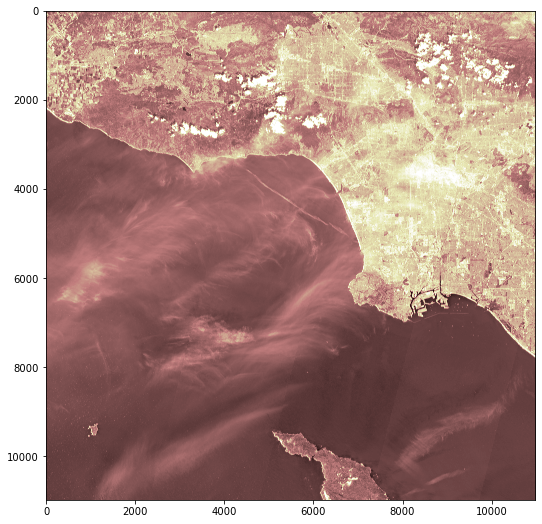

In [8]:
url='https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/TCI.tif'
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
src = rasterio.open(url)
fig, ax = plt.subplots(figsize=(12, 9))
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

## Masking a COG

In [9]:
def read_imagery(path):
    data = rasterio.open(path)
    masked, mask_transform = mask(dataset=data, shapes=gdf.geometry, crop=True)
    print(masked.shape)
    return data, masked[0,:,:], mask_transform

In [10]:
gdf = gpd.read_file('bounds.geojson')
data = rio.open(url)

#### Reprojecting the geometry to the same CRS as the raster

In [11]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
data.crs

CRS.from_epsg(32611)

In [13]:
# Project the Polygon into same CRS as the raster
gdf = gdf.to_crs(crs=data.crs)

# Print crs
gdf.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
data, masked, mask_transform = read_imagery(url)

(3, 881, 1582)


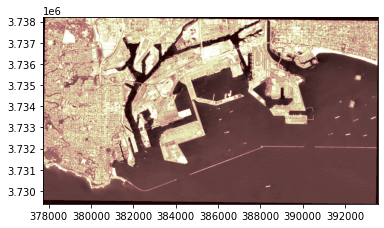

<AxesSubplot:>

In [15]:
show(masked, transform=mask_transform, cmap='pink')

### Overviews

In [16]:
import rasterio as rio

with rio.open(url) as src:
    hls_ov_levels = src.overviews(1)
hls_ov_levels

[2, 4, 8, 16]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
<xarray.DataArray (band: 3, y: 1373, x: 1373)>
dask.array<open_rasterio-92f061b88a9b6ab8656956b710575c28<this-array>, shape=(3, 1373, 1373), dtype=float32, chunksize=(1, 1373, 1373), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 3e+05 3.001e+05 3.002e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 3.8e+06 3.8e+06 3.8e+06 ... 3.69e+06 3.69e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


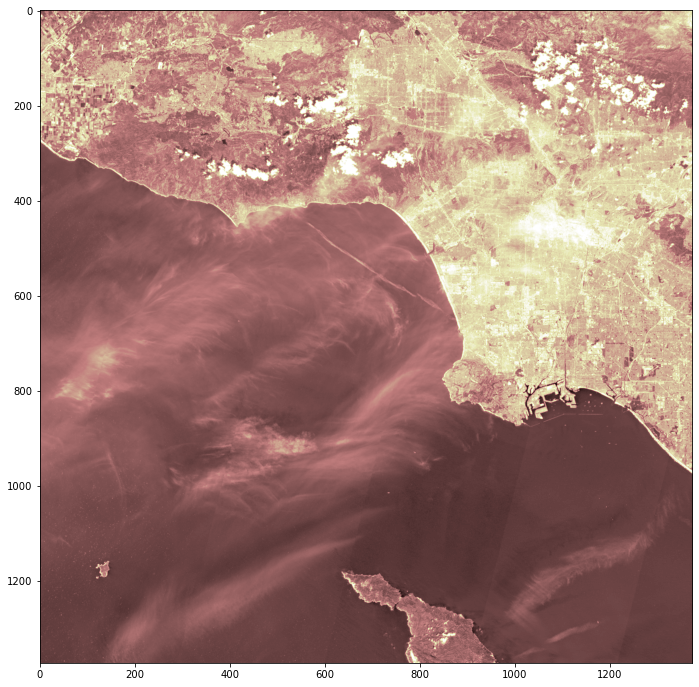

In [17]:
import rioxarray
%time
with rioxarray.open_rasterio(url, masked=True, overview_level=2, chunks=True) as src:    # https://nbviewer.jupyter.org/gist/rsignell-usgs/f4dd62ad1274c5b5ed69e5a6b81c1295 & http://rasterio.readthedocs.io/en/latest/topics/resampling.html
        fig, ax = plt.subplots(1, figsize=(12, 12))
        print(src)
        pyplot.imshow(src[0], cmap='pink')

In [18]:
%%bash
url='https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LT/2019/4/S2B_11SLT_20190409_0_L2A/B01.tif'

rio info $url | python -m json.tool

{
    "blockxsize": 256,
    "blockysize": 256,
    "bounds": [
        300000.0,
        3690240.0,
        409800.0,
        3800040.0
    ],
    "colorinterp": [
        "gray"
    ],
    "compress": "deflate",
    "count": 1,
    "crs": "EPSG:32611",
    "descriptions": [
        null
    ],
    "driver": "GTiff",
    "dtype": "uint16",
    "height": 1830,
    "indexes": [
        1
    ],
    "interleave": "band",
    "lnglat": [
        -118.56816129422707,
        33.83655865192957
    ],
    "mask_flags": [
        [
            "nodata"
        ]
    ],
    "nodata": 0.0,
    "res": [
        60.0,
        60.0
    ],
    "shape": [
        1830,
        1830
    ],
    "tiled": true,
    "transform": [
        60.0,
        0.0,
        300000.0,
        0.0,
        -60.0,
        3800040.0,
        0.0,
        0.0,
        1.0
    ],
    "units": [
        null
    ],
    "width": 1830
}
